## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import networkx as nx
import numpy as np
import pandas as pd
import time

In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib.colors as mcol
import matplotlib.cm as cm
import seaborn as sns
sns.set_style('whitegrid')

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["font.size"] = 12
csfont = {'fontname':'Times New Roman'}

In [4]:
from curvature import give_graph_ricci
from sdrf import stochastic_discrete_ricci_flow
from synthetic import generate_graph_barbell

In [5]:
from torch_geometric.transforms import GDC
from torch_geometric.utils.convert import to_networkx, from_networkx

def do_digl(g, gdc=None, eps=1):
    if gdc is None:
        gdc = GDC(sparsification_kwargs={'method':'threshold', 'eps':eps})
    return to_networkx(gdc(from_networkx(g)))

## Generate graphs, apply SDRF and GDC and calculate metrics

In [6]:
sdrf_metrics = pd.DataFrame(0, index=range(11), columns=['cmin','cmean', 'cmax', 'nbmin', 'nbmean', 'nbmax', 'ebmin', 'ebmean', 'ebmax', 'eigenvalue', 'cheeger_lower', 'cheeger_upper', 'cheeger_approx', 'convergedness'])
digl_metrics = pd.DataFrame(0, index=range(11), columns=['cmin','cmean', 'cmax', 'nbmin', 'nbmean', 'nbmax', 'ebmin', 'ebmean', 'ebmax', 'eigenvalue', 'cheeger_lower', 'cheeger_upper', 'cheeger_approx', 'disconnectedness', 'avg_degree'])
MAX_STEPS = 10
initial_graphs = []
sdrf_graphs = []
digl_graphs = []
N = 100

In [7]:
start_time = time.time()

for i in range(N):
    G = generate_graph_barbell(15, 0.4, 2, correlation=-0.1, make_binary=True)
    initial_graphs.append(G)
    
    graphs = stochastic_discrete_ricci_flow(G, 'unbiased_forman', target_curvature=0, scaling=50, max_steps=10)
    if len(graphs) < (MAX_STEPS+1):
        for j in range(len(graphs), MAX_STEPS+1):
            sdrf_metrics.loc[j, 'convergedness'] += 1
        graphs += [graphs[-1] for _ in range(MAX_STEPS+1 - len(graphs))]
    sdrf_graphs.append(graphs)
    for i in range(len(graphs)):
        give_graph_ricci(graphs[i])
        ricci = [v['ricci'] for k,v in graphs[i].edges.items()]
        sdrf_metrics.loc[i, 'cmin'] += min(ricci)
        sdrf_metrics.loc[i, 'cmean'] += np.mean(ricci)
        sdrf_metrics.loc[i, 'cmax'] += max(ricci)
        centralities = list(nx.betweenness_centrality(graphs[i]).values())
        sdrf_metrics.loc[i, 'nbmin'] += min(centralities)
        sdrf_metrics.loc[i, 'nbmean'] += np.mean(centralities)
        sdrf_metrics.loc[i, 'nbmax'] += max(centralities)
        centralities = list(nx.edge_betweenness_centrality(graphs[i]).values())
        sdrf_metrics.loc[i, 'ebmin'] += min(centralities)
        sdrf_metrics.loc[i, 'ebmean'] += np.mean(centralities)
        sdrf_metrics.loc[i, 'ebmax'] += max(centralities)
        
        spectrum = nx.spectrum.laplacian_spectrum(graphs[i])
        if nx.is_connected(graphs[i]) and np.any(spectrum.round(10) > 0):
            eigenvalue = spectrum[spectrum.round(10) > 0][0]
            sdrf_metrics.loc[i, 'eigenvalue'] += eigenvalue
            sdrf_metrics.loc[i, 'cheeger_lower'] += eigenvalue/2
            sdrf_metrics.loc[i, 'cheeger_upper'] += np.sqrt(2 * eigenvalue * max([t[1] for t in graphs[i].degree]))
            sdrf_metrics.loc[i, 'cheeger_approx'] += min([len(list(nx.edge_boundary(graphs[i], range(15)))), len(list(nx.edge_boundary(graphs[i], range(15,30))))])/15
       
    G = G.copy()
    
    graphs = []
    for i, eps in enumerate(np.logspace(-3,-1,11)):
        G_digl = do_digl(G, eps=eps).to_undirected()
        graphs.append(G_digl)
        give_graph_ricci(G_digl)
        ricci = [v['ricci'] for k,v in G_digl.edges.items()]
        digl_metrics.loc[i, 'cmin'] += min(ricci)
        digl_metrics.loc[i, 'cmean'] += np.mean(ricci)
        digl_metrics.loc[i, 'cmax'] += max(ricci)
        centralities = list(nx.betweenness_centrality(G_digl).values())
        digl_metrics.loc[i, 'nbmin'] += min(centralities)
        digl_metrics.loc[i, 'nbmean'] += np.mean(centralities)
        digl_metrics.loc[i, 'nbmax'] += max(centralities)
        centralities = list(nx.edge_betweenness_centrality(G_digl).values())
        digl_metrics.loc[i, 'ebmin'] += min(centralities)
        digl_metrics.loc[i, 'ebmean'] += np.mean(centralities)
        digl_metrics.loc[i, 'ebmax'] += max(centralities)
    
        spectrum = nx.spectrum.laplacian_spectrum(G_digl)
        if not nx.is_connected(G_digl):
            digl_metrics.loc[i, 'disconnectedness'] += 1
        elif np.any(spectrum.round(10) > 0):
            eigenvalue = spectrum[spectrum.round(10) > 0][0]
            digl_metrics.loc[i, 'eigenvalue'] += eigenvalue
            digl_metrics.loc[i, 'cheeger_lower'] += eigenvalue/2
            digl_metrics.loc[i, 'cheeger_upper'] += np.sqrt(2 * eigenvalue * max([t[1] for t in G_digl.degree]))
            digl_metrics.loc[i, 'cheeger_approx'] += min([len(list(nx.edge_boundary(G_digl, range(15)))), len(list(nx.edge_boundary(G_digl, range(15,30))))])/15
        
        digl_metrics.loc[i, 'avg_degree'] += np.mean(list(dict(G_digl.degree).values()))
        
    digl_graphs.append(graphs)

sdrf_metrics /= N
digl_metrics /= N

print(time.time() - start_time)

63.24524235725403


In [8]:
sdrf_metrics

,cmin,cmean,cmax,nbmin,nbmean,nbmax,ebmin,ebmean,ebmax,eigenvalue,cheeger_lower,cheeger_upper,cheeger_approx,convergedness
0,-1.3678,-0.118212,0.7808,0.000492,0.068252,0.536307,0.004495,0.035072,0.517241,0.096042,0.048021,1.335460,0.066667,0.00
1,-1.1304,-0.133727,0.7375,0.000590,0.063891,0.468301,0.004666,0.033242,0.359835,0.155823,0.077912,1.699850,0.123333,0.13
2,-1.0911,-0.133025,0.7276,0.000582,0.062570,0.460782,0.004702,0.032480,0.324725,0.179229,0.089615,1.820196,0.148000,0.19
3,-1.0516,-0.131386,0.7217,0.000565,0.061454,0.453891,0.004703,0.031836,0.298146,0.199534,0.099767,1.919772,0.171333,0.26
4,-1.0188,-0.127333,0.7215,0.000557,0.060650,0.448429,0.004633,0.031313,0.284905,0.214537,0.107269,1.999515,0.188000,0.29
5,-0.9962,-0.123397,0.7184,0.000581,0.059950,0.444836,0.004658,0.030856,0.273901,0.226601,0.113301,2.056881,0.201333,0.33
6,-0.9767,-0.117606,0.7158,0.000555,0.059454,0.441945,0.004640,0.030477,0.267649,0.234999,0.117499,2.094891,0.210000,0.35
7,-0.9684,-0.115103,0.7105,0.000568,0.058820,0.434681,0.004722,0.030079,0.261261,0.245241,0.122620,2.145346,0.222667,0.41
8,-0.9593,-0.114320,0.7025,0.000559,0.058308,0.432561,0.004740,0.029734,0.255199,0.255221,0.127611,2.191504,0.231333,0.43
9,-0.9386,-0.110754,0.7004,0.000573,0.057840,0.430339,0.004716,0.029415,0.249619,0.264598,0.132299,2.236438,0.242000,0.43


In [9]:
digl_metrics

,cmin,cmean,cmax,nbmin,nbmean,nbmax,ebmin,ebmean,ebmax,eigenvalue,cheeger_lower,cheeger_upper,cheeger_approx,disconnectedness,avg_degree
0,0.4516,0.946337,1.2101,0.000000,0.003091,0.006094,0.0,0.002556,0.004101,16.826422,8.413211,32.157164,12.478000,0.00,28.475494
1,0.1274,0.776295,1.2502,0.000000,0.008089,0.028433,0.0,0.003369,0.007529,10.145575,5.072788,24.973976,8.428000,0.00,24.423057
2,-0.1815,0.789865,1.2518,0.000000,0.013486,0.114350,0.0,0.004591,0.014486,4.801993,2.400997,17.192156,4.053333,0.00,20.045885
3,0.0530,1.023377,1.2630,0.000000,0.016115,0.250117,0.0,0.005402,0.028335,2.062433,1.031217,11.267867,1.929333,0.00,17.921057
4,-0.4018,1.030484,1.2706,0.000000,0.018440,0.309872,0.0,0.005852,0.032538,1.535859,0.767930,9.258154,1.295333,0.00,17.286000
5,-0.9687,1.119878,1.2722,0.000000,0.027010,0.374423,0.0,0.007099,0.135127,0.759176,0.379588,5.564624,0.537333,0.00,16.521425
6,-1.3708,1.227123,1.2945,0.000000,0.034737,0.513012,0.0,0.008236,0.510204,0.127083,0.063541,2.055439,0.073333,0.00,15.975149
7,-1.3308,1.149495,1.4555,0.000000,0.037498,0.518848,0.0,0.008920,0.517241,0.116855,0.058427,1.984944,0.066667,0.00,15.347310
8,-0.0869,0.907918,2.3158,0.000000,0.020211,0.157808,0.0,0.007143,0.148873,0.024832,0.012416,0.450052,0.017333,0.74,11.167218
9,-0.2327,0.829432,3.2790,0.000087,0.013108,0.054359,0.0,0.007946,0.031616,0.000555,0.000277,0.011538,0.000667,0.99,7.112184


Text(0, 0.5, 'Ricci curvature')

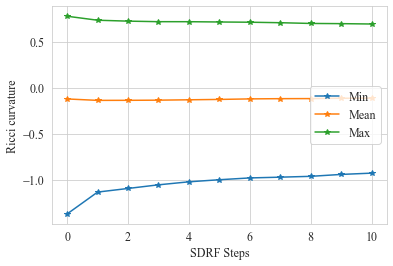

In [10]:
sdrf_metrics[['cmin', 'cmean', 'cmax']].plot(marker='*')
plt.legend(['Min', 'Mean', 'Max'], loc='center right')
plt.xlabel('SDRF Steps',**csfont)
plt.ylabel('Ricci curvature')

Text(0, 0.5, 'Node betweenness centrality')

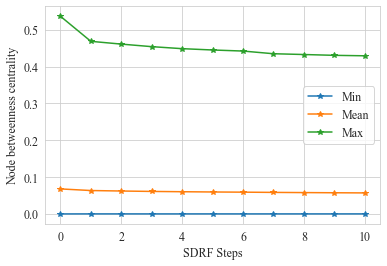

In [11]:
sdrf_metrics[['nbmin', 'nbmean', 'nbmax']].plot(marker='*')
plt.legend(['Min', 'Mean', 'Max'])
plt.xlabel('SDRF Steps')
plt.ylabel('Node betweenness centrality')

Text(0, 0.5, 'Edge betweenness centrality')

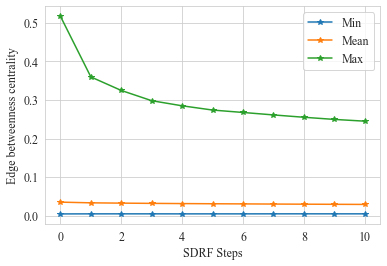

In [12]:
sdrf_metrics[['ebmin', 'ebmean', 'ebmax']].plot(marker='*')
plt.legend(['Min', 'Mean', 'Max'])
plt.xlabel('SDRF Steps')
plt.ylabel('Edge betweenness centrality')

Text(0, 0.5, 'Cheeger constant bounds')

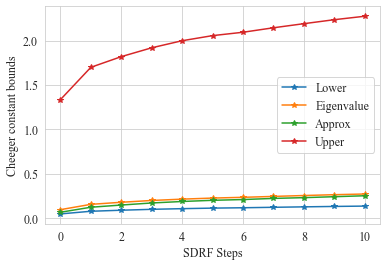

In [13]:
sdrf_metrics[['cheeger_lower', 'eigenvalue', 'cheeger_approx', 'cheeger_upper']].plot(marker='*')
plt.legend(['Lower', 'Eigenvalue', 'Approx', 'Upper'])
plt.xlabel('SDRF Steps')
plt.ylabel('Cheeger constant bounds')

([<matplotlib.axis.XTick at 0x7f7e2802dcf8>,
 [Text(0, 0, '0.001'), Text(5, 0, '0.01'), Text(10, 0, '0.1')])

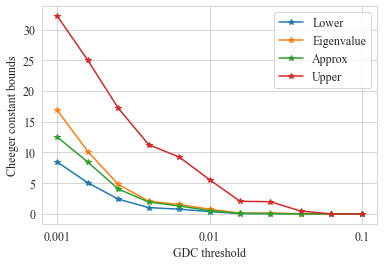

In [14]:
digl_metrics[['cheeger_lower', 'eigenvalue', 'cheeger_approx', 'cheeger_upper']].plot(marker='*')
plt.legend(['Lower', 'Eigenvalue', 'Approx', 'Upper'])
plt.xlabel('GDC threshold')
plt.ylabel('Cheeger constant bounds')
plt.xticks([0,5,10], [0.001,0.01,0.1])

([<matplotlib.axis.XTick at 0x7f7e281b3400>,
 [Text(0, 0, '0.001'), Text(5, 0, '0.01'), Text(10, 0, '0.1')])

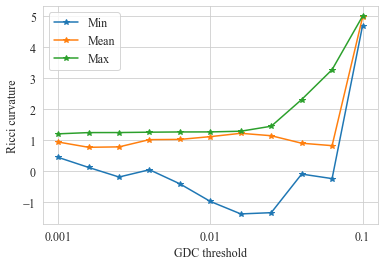

In [15]:
digl_metrics[['cmin', 'cmean', 'cmax']].plot(marker='*')
plt.legend(['Min', 'Mean', 'Max'])
plt.xlabel('GDC threshold')
plt.ylabel('Ricci curvature')
plt.xticks([0,5,10], [0.001,0.01,0.1])

([<matplotlib.axis.XTick at 0x7f7e27f1e518>,
 [Text(0, 0, '0.001'), Text(5, 0, '0.01'), Text(10, 0, '0.1')])

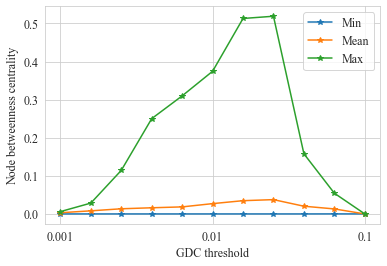

In [16]:
digl_metrics[['nbmin', 'nbmean', 'nbmax']].plot(marker='*')
plt.legend(['Min', 'Mean', 'Max'])
plt.xlabel('GDC threshold')
plt.ylabel('Node betweenness centrality')
plt.xticks([0,5,10], [0.001,0.01,0.1])

([<matplotlib.axis.XTick at 0x7f7e27e93c88>,
 [Text(0, 0, '0.001'), Text(5, 0, '0.01'), Text(10, 0, '0.1')])

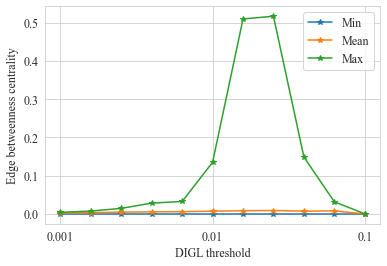

In [17]:
digl_metrics[['ebmin', 'ebmean', 'ebmax']].plot(marker='*')
plt.legend(['Min', 'Mean', 'Max'])
plt.xlabel('DIGL threshold')
plt.ylabel('Edge betweenness centrality')
plt.xticks([0,5,10], [0.001,0.01,0.1])

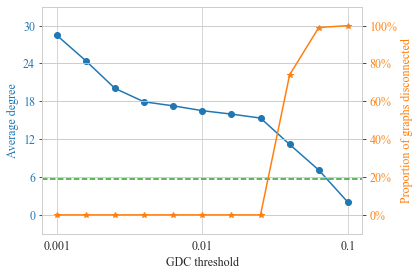

In [18]:
fig, ax1 = plt.subplots()

t = digl_metrics.index
data1 = digl_metrics.avg_degree.values
data2 = digl_metrics.disconnectedness.values

color = 'C0'
ax1.set_xlabel('GDC threshold')
ax1.set_ylabel('Average degree', color=color)
ax1.plot(t, data1, color=color, marker='o')
ax1.set_yticks([0,6,12,18,24,30])
ax1.set_ylim((-3,33))
ax1.tick_params(axis='y', labelcolor=color)
plt.axhline(5.66, linestyle='--', color='C2', label='Original average degree')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'C1'
ax2.set_ylabel('Proportion of graphs disconnected', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color, marker='*')
ax2.set_yticklabels(['', '0%', '20%', '40%', '60%', '80%', '100%'])
ax2.set_ylim((-0.1,1.1))
ax2.tick_params(axis='y', labelcolor=color)

plt.xticks([0,5,10], [0.001,0.01,0.1])

fig.tight_layout()  # otherwise the right y-label is slightly clipped

## Plot example graphs

In [19]:
def plot_graph_w_ricci_coloring(G, pos=None, ricci_func=None, color_nodes_avg_curvature=False, color_nodes_y=False, label_nodes=False, seed=None):
    fig, ax = plt.subplots()
    fig.set_size_inches(7,7)
    ax.axis("off")
    
    if ricci_func is not None:
        give_graph_ricci(G, ricci_func)
    
    max_curvature = np.array([G.edges[x,y]['ricci'] for x, y in G.edges]).max()
    min_curvature = np.array([G.edges[x,y]['ricci'] for x, y in G.edges]).min()
    cm1 = mcol.LinearSegmentedColormap.from_list("positivty",["b","r"])
    cnorm = mcol.Normalize(vmin=min_curvature,vmax=max_curvature)
    cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)
    
    if pos is None:
        pos = nx.spring_layout(G, seed)
    
    edges = G.edges
    edge_colors = [cpick.to_rgba(edges[x,y]['ricci']) for x,y in edges]
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_colors, width=4)
    
    if color_nodes_avg_curvature:
        nodes = G.nodes
        node_colors = [cpick.to_rgba(np.mean([G.edges[x,y]['ricci'] for y in G.neighbors(x)])) for x in nodes]
        nx.draw_networkx_nodes(G, pos, node_size=250, node_color=node_colors, edgecolors='black')
    elif color_nodes_y:
        nodes = G.nodes
        node_colors = [cpick.to_rgba(G.nodes[x]['y']) for x in nodes]
        nx.draw_networkx_nodes(G, pos, node_size=250, node_color=node_colors, edgecolors='black')
    else:
        nx.draw_networkx_nodes(G, pos, node_size=250, node_color='white', edgecolors='black')
    
    if label_nodes:
        nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

    plt.colorbar(cpick,label="Ricci curvature")

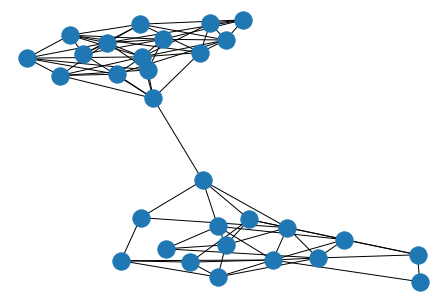

In [20]:
pos_ = nx.spring_layout(sdrf_graphs[3][0])
nx.draw(sdrf_graphs[3][0], pos=pos_)

0 SDRF step(s) completed


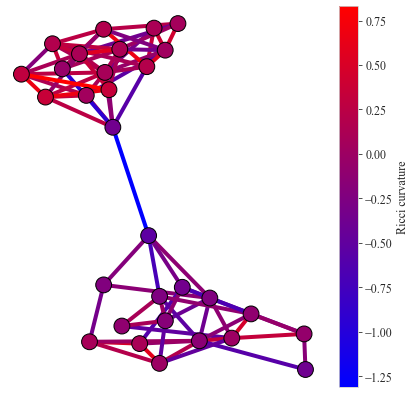

1 SDRF step(s) completed


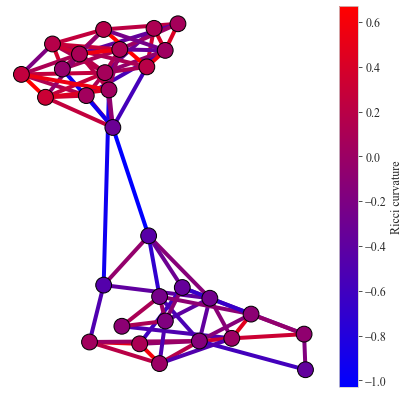

2 SDRF step(s) completed


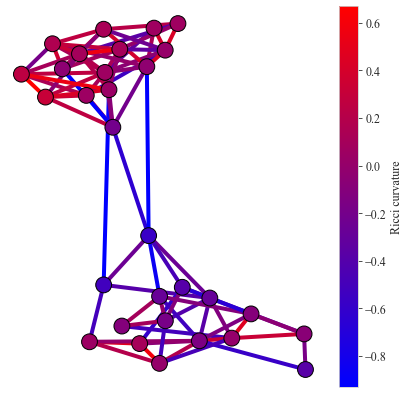

3 SDRF step(s) completed


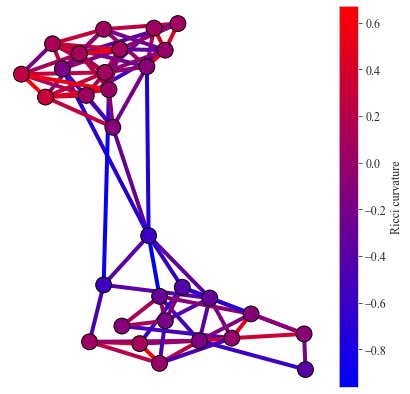

4 SDRF step(s) completed


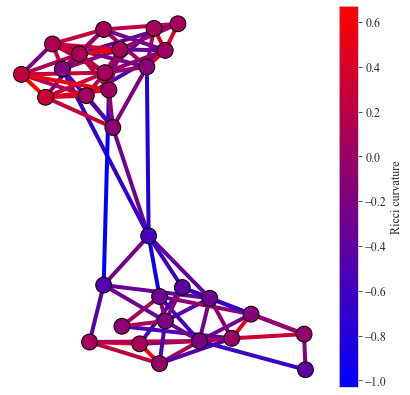

5 SDRF step(s) completed


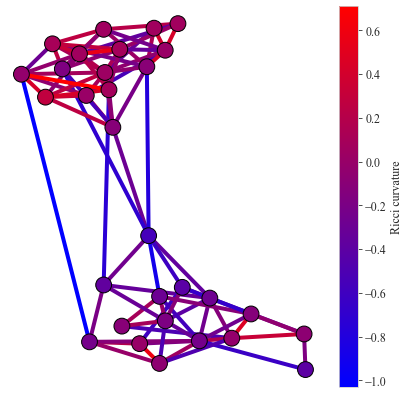

6 SDRF step(s) completed


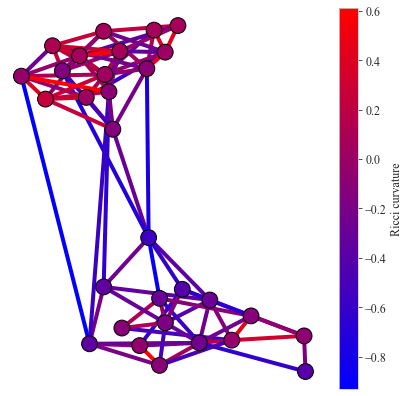

7 SDRF step(s) completed


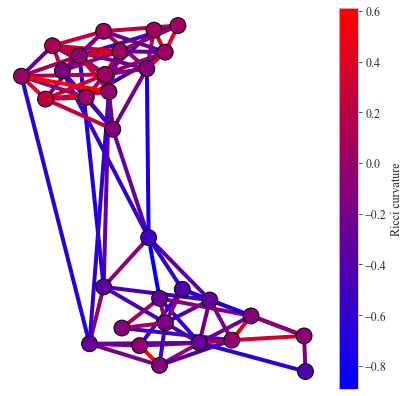

8 SDRF step(s) completed


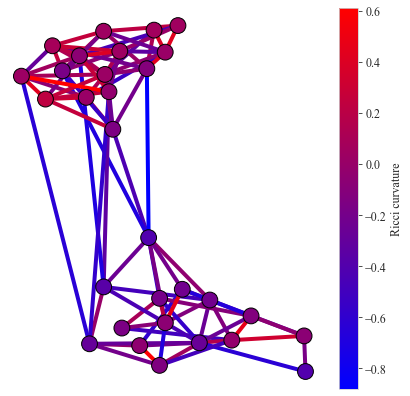

9 SDRF step(s) completed


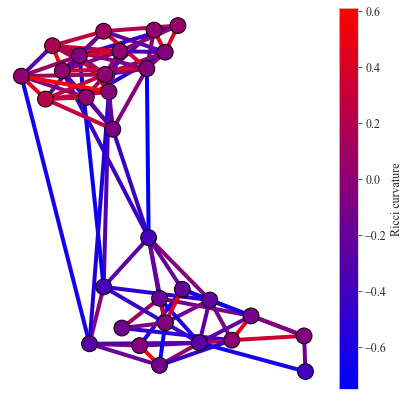

10 SDRF step(s) completed


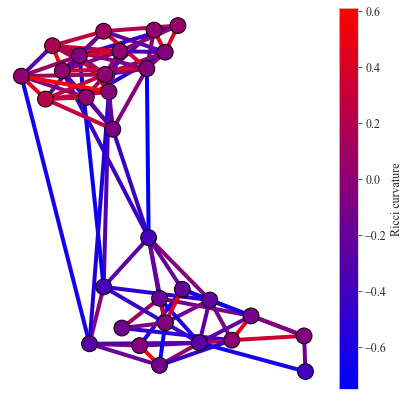

In [21]:
for i in range(11):
    print(f'{i} SDRF step(s) completed')
    plot_graph_w_ricci_coloring(sdrf_graphs[3][i], pos=pos_, color_nodes_avg_curvature=True)
    plt.show()

GDC applied with threshold epsilon=0.001


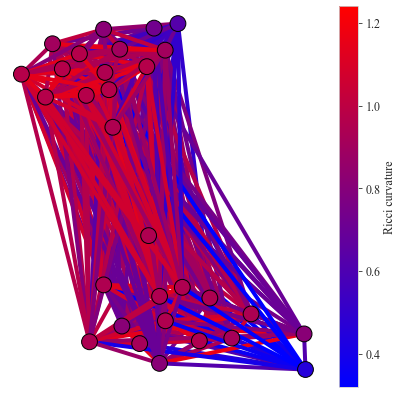

GDC applied with threshold epsilon=0.001584893192461114


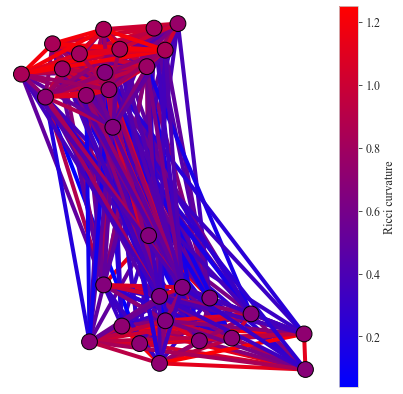

GDC applied with threshold epsilon=0.0025118864315095794


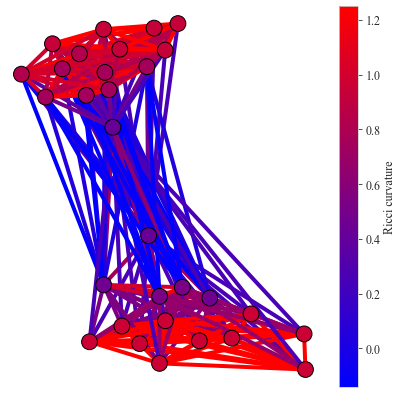

GDC applied with threshold epsilon=0.003981071705534973


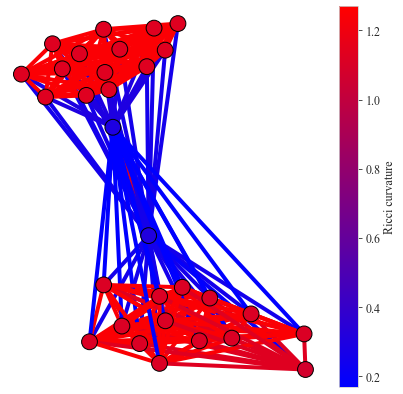

GDC applied with threshold epsilon=0.00630957344480193


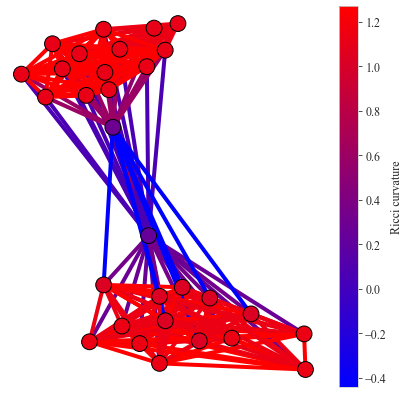

GDC applied with threshold epsilon=0.01


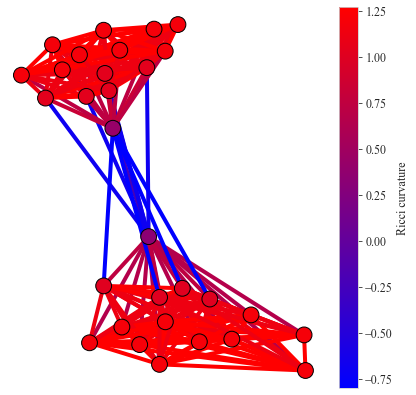

GDC applied with threshold epsilon=0.01584893192461114


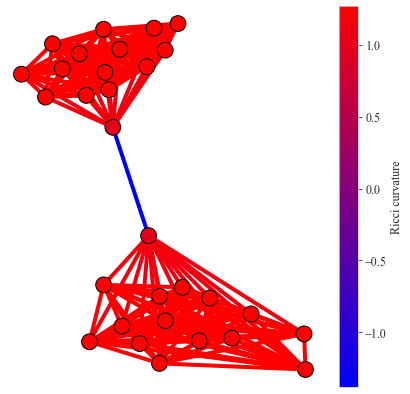

GDC applied with threshold epsilon=0.025118864315095808


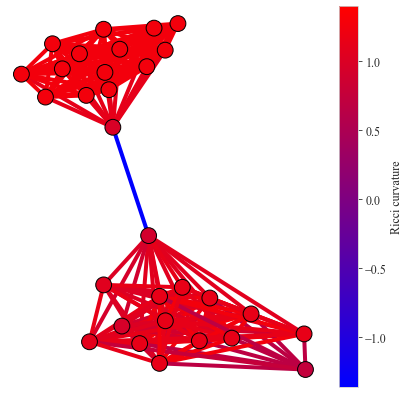

GDC applied with threshold epsilon=0.039810717055349734


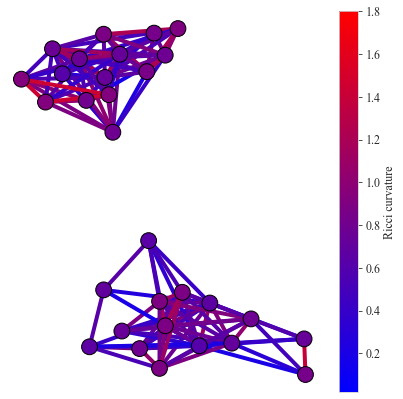

GDC applied with threshold epsilon=0.06309573444801933


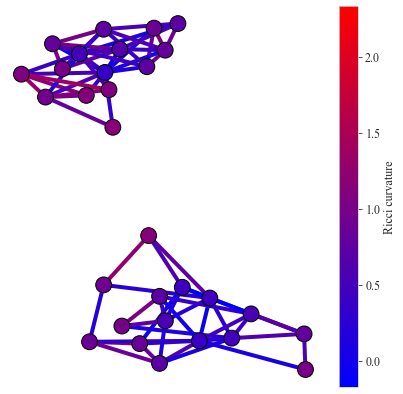

GDC applied with threshold epsilon=0.1


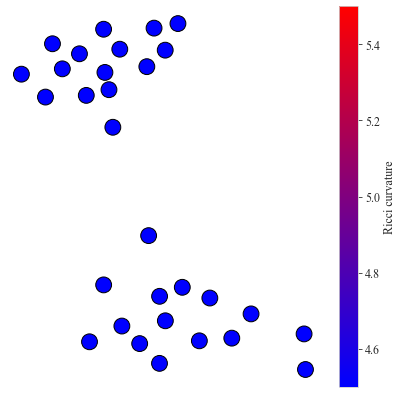

In [22]:
for i, eps in enumerate(np.logspace(-3,-1,11)):
    print(f'GDC applied with threshold epsilon={eps}')
    plot_graph_w_ricci_coloring(digl_graphs[3][i], pos=pos_, color_nodes_avg_curvature=True)
    plt.show()